# First algorithm: Extracting/analyzing data of interest and then organize it for NNs 

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt 
from matplotlib.dates import DateFormatter
import datetime
import numpy as np
from numpy import interp
from itertools import compress
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl
from scipy import stats
import copy

## Extract data, perform quick analysis over it and organize it temporally

In [2]:
df_product_info = pd.read_csv('product.csv')
df_district_info = pd.read_csv('service_delivery_site_data.csv') 
print(f'Total contraceptive products: {len(df_product_info)}')
print(f'Total of districts: {len(df_district_info)}')
print(f'Total cases:  {len(df_product_info) * len(df_district_info)}')
df_data = pd.read_csv('Train.csv')

Total contraceptive products: 11
Total of districts: 156
Total cases:  1716


In [3]:
df_data.describe()

,year,month,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered
count,35753.000000,35753.000000,35753.000000,35753.000000,35753.000000,35753.000000,35753.000000,35753.000000,35753.0,34990.000000
mean,2017.433782,6.169412,63.245518,14.846055,14.764327,0.961150,64.288395,14.606439,0.0,26.658102
std,1.019933,3.429079,168.661538,70.631782,39.848242,37.883099,170.848479,32.521384,0.0,107.166082
min,2016.000000,1.000000,0.000000,0.000000,0.000000,-1440.000000,0.000000,0.000000,0.0,0.000000
25%,2017.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,2017.000000,6.000000,12.000000,0.000000,1.000000,0.000000,13.000000,3.000000,0.0,0.000000
75%,2018.000000,9.000000,69.000000,0.000000,13.000000,0.000000,70.000000,16.000000,0.0,20.000000
max,2019.000000,12.000000,4320.000000,3534.000000,1728.000000,3003.000000,4320.000000,864.000000,0.0,10240.000000


Check how the target variable is distributed 

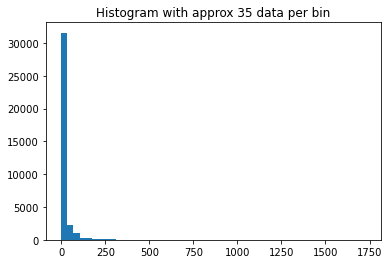

In [4]:
stock_distributed = df_data['stock_distributed'].values
plt.figure()
_ = plt.hist(stock_distributed, bins=50)  
plt.title("Histogram with approx 35 data per bin")
plt.show()

In [5]:
print(f'max value (target variable): {np.max(stock_distributed)}')
print(f'mean value (target variable): {np.mean(stock_distributed)}')
print(f'median value (target variable): {np.median(stock_distributed)}')
print(f'minimum value (target variable): {np.min(stock_distributed)}')
print(f'mode value (target variable): {stats.mode(stock_distributed)[0][0]}')

stock_dist = stock_distributed[stock_distributed>0]
perc_null = len(stock_dist)/len(stock_distributed) *100
print(f'{perc_null}% of the target variable is not null')

max value (target variable): 1728
mean value (target variable): 14.764327469023579
median value (target variable): 1.0
minimum value (target variable): 0
mode value (target variable): 0
50.387380079993285% of the target variable is not null


The vast majority of information is null! 
What would happen to the distribution of data if null data is ignored? 

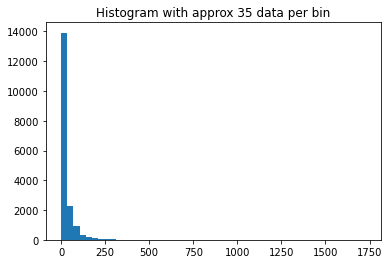

In [6]:
plt.figure()
_ = plt.hist(stock_dist, bins=50)  
plt.title("Histogram with approx 35 data per bin")
plt.show()

In [7]:
print(f'max value (target variable): {np.max(stock_dist)}')
print(f'mean value (target variable): {np.mean(stock_dist)}')
print(f'median value (target variable): {np.median(stock_dist)}')
print(f'minimum value (target variable): {np.min(stock_dist)}')
print(f'mode value (target variable): {stats.mode(stock_dist)[0][0]}')

max value (target variable): 1728
mean value (target variable): 29.30163752428532
median value (target variable): 13.0
minimum value (target variable): 1
mode value (target variable): 1


The vast majority of information is concentrated in the range [1, 35]

Text(0.5, 1.0, 'Box plot of target variable (No-zero values)')

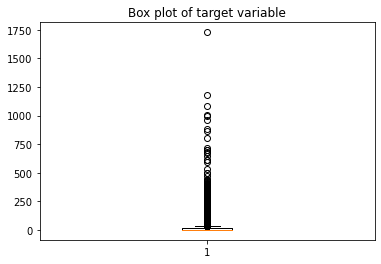

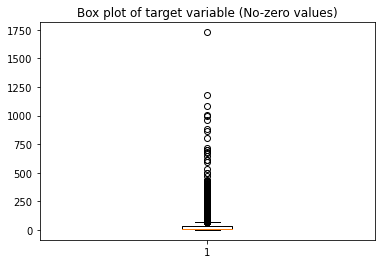

In [8]:
plt.figure()
plt.boxplot(stock_distributed)
plt.title("Box plot of target variable")

plt.figure()
plt.boxplot(stock_dist)
plt.title("Box plot of target variable (No-zero values)")

The data is not normally distributed or there are many outliers? 

Let's check the relationship of the target variable with respect other variables to see if there are some outliers (values not supported by the other variables). In practice, it is checked if the sum of stock_initial, stock_received and stock_adjustment minus stock_distributed (target value) correspond always to stock_end.

In [9]:
stock_initial = df_data['stock_initial'].values
stock_received = df_data['stock_received'].values
stock_adjustment = df_data['stock_adjustment'].values
stock_end = df_data['stock_end'].values

stock_end_pred = stock_initial + stock_received + stock_adjustment - stock_distributed

if sum(stock_end_pred ==  stock_end) == len(stock_end):
    print('If they are any outliers, other data will not be helpful! \n')


If they are any outliers, other data will not be helpful! 



Extract relevant data based on the problem and scale/normalize the target data (In this version average_monthly_consumption is ignored)

In [10]:
df_data_reduced = df_data[['year', 'month', 'product_code', 'site_code', 'average_monthly_consumption', 'stock_distributed']]
scaler = MinMaxScaler()
df_data_reduced['stock_distributed'] = scaler.fit_transform(df_data_reduced['stock_distributed'].values.reshape(-1,1))
filehandler = open('scaler_final.pkl', 'wb') 
pkl.dump(scaler, filehandler)
filehandler.close()

C:\Users\dcamp\Anaconda3\envs\tf_gpu_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
df_data_reduced.describe()

,year,month,average_monthly_consumption,stock_distributed
count,35753.000000,35753.000000,35753.000000,35753.000000
mean,2017.433782,6.169412,14.606439,0.008544
std,1.019933,3.429079,32.521384,0.023060
min,2016.000000,1.000000,0.000000,0.000000
25%,2017.000000,3.000000,0.000000,0.000000
50%,2017.000000,6.000000,3.000000,0.000579
75%,2018.000000,9.000000,16.000000,0.007523
max,2019.000000,12.000000,864.000000,1.000000


Reorganize information from training data chronologically, then by product and finally by district

In [12]:
df_data_reduced = df_data_reduced.sort_values(by=['year', 'month', 'product_code', 'site_code'])
filehandler = open('df_data_final.pkl', 'wb') 
pkl.dump(df_data_reduced, filehandler)
filehandler.close()


In [13]:
df_data_reduced.head()

,year,month,product_code,site_code,average_monthly_consumption,stock_distributed
31878,2016,1,AS17005,C1015,0,0.0
31891,2016,1,AS17005,C1024,0,0.0
27813,2016,1,AS17005,C1026,0,0.0
35278,2016,1,AS17005,C1028,0,0.0
28288,2016,1,AS17005,C1062,0,0.0


In [14]:
if df_data_reduced.isna().values.any():    
    print(f'The data has {df_data_reduced.isna().sum().sum()} NaN values')
else:
    print('The data does not have NaN values!')

The data does not have NaN values!


## Select a given product in a given district and see how it behaves through time. Note that the case analyzed ut is just a one among 1716

In [15]:
product_codes = list(df_product_info['product_code'])
site_codes = list(df_district_info['site_code'])
total_cases = len(df_product_info) * len(df_district_info)

random.seed(125)
prod_id = random.randint(0, len(product_codes)-1)
site_id = random.randint(0, len(site_codes)-1)
product_rand = product_codes[prod_id] # 'product_code'
site_rand = site_codes[site_id] # 'site_code'

Text(0.5, 1.0, 'Product: AS27137 and site: C1072 (41 out of 42 instances)')

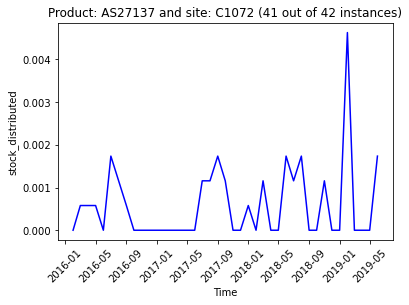

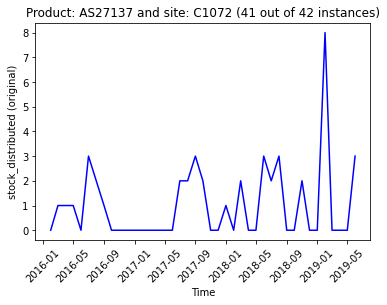

In [16]:
df_single_case = df_data_reduced[df_data_reduced['product_code'].str.contains(product_rand)]
df_single_case = df_single_case[df_single_case["site_code"].str.contains(site_rand)]

date_x = [datetime.date(list(df_single_case['year'])[i], list(df_single_case['month'])[i], 1) for i in range(df_single_case.shape[0])]
date_form = DateFormatter("%Y-%m")
fig, ax = plt.subplots() 
plt.plot_date(date_x, np.array(df_single_case['stock_distributed']), 'b-')
plt.ylabel('stock_distributed')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title(f'Product: {product_rand} and site: {site_rand} ({len(df_single_case)} out of 42 instances)')

fig, ax = plt.subplots() 
plt.plot_date(date_x, scaler.inverse_transform(np.array(df_single_case['stock_distributed']).reshape(-1,1)), 'b-')
plt.ylabel('stock_distributed (original)')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title(f'Product: {product_rand} and site: {site_rand} ({len(df_single_case)} out of 42 instances)')


The percentage of data available per each date (year/month). Each date should have 1716 instances if data is complete.  

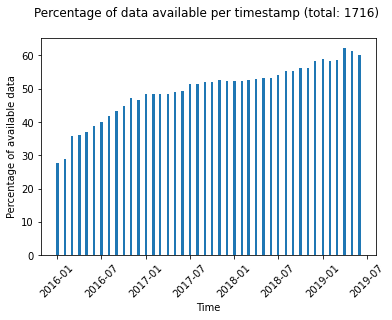

In [17]:
years = np.unique(np.array(df_data_reduced['year']))
dict_year_month_codification = {}
id_time = -1
date_x = []
percentage_of_data_y = []
for i in years:
    df_year = df_data_reduced[df_data_reduced['year'] == i]
    months = np.unique(np.array(df_year['month']))
    for j in months:
        id_time += 1
        dict_year_month_codification[str(i) + '-' + str(j)] = id_time
        date_x.append(datetime.date(i, j, 1))
        percentage_of_data_y.append(len(df_year[df_year['month'] == j])/total_cases*100)
        
# Plot the amount of data available per timestamp with respect the theoretical amount of information
fig, ax = plt.subplots() 
ax.bar(date_x, percentage_of_data_y, width=10)
plt.ylabel('Percentage of available data')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title(f'Percentage of data available per timestamp (total: {total_cases}) \n')

time_series_per_case_training = {}
summary_cases = {'informative_cases': [], 'incomplete_cases': [], 'null_cases': []}


## Fill unexistent data based on available information of the product per district

Function that performs a piecewise division of a time series given a maximum gap allowed between time instances and the minimum size of the resultant piecewise series. Pieacewise time and data are interpolated later.    

In [18]:
def piecewise_division(series_time, series_data, max_gap, min_series_size):
    # Calculate indexes where gaps start
    series_time = np.append(series_time, series_time[-1]+1)
    series_encoded = np.diff(series_time) > max_gap
    series_encoded = np.array(list(compress(range(len(series_encoded)), series_encoded)))
    
    # Calculate the places where a gap ends, include first and last indexes
    relevant_positions = np.append(np.array([0]), series_encoded + 1)
    relevant_positions = np.append(relevant_positions, len(series_time)-1)
    relevant_positions = np.unique(relevant_positions)
    
    # Calculate indexes of ending gaps from which valid windows can be extracted
    windows_encoded = np.diff(relevant_positions) >= min_series_size
    windows_encoded = np.array(list(compress(range(len(windows_encoded)), windows_encoded)))
    
    series_time_output = []
    series_data_output = []
    for i in windows_encoded:
        final_indexes = np.array(range(int(relevant_positions[i]), 
                                       int(relevant_positions[i + 1]))) 
        series_time_output.append(series_time[final_indexes])
        series_data_output.append(series_data[final_indexes])
    return series_time_output, series_data_output   

Function that allows to grow the dataset to be fed to the network

In [19]:
def update_dataset(dataset_input, dataset_output, 
                   stock_single_case_complete, mem_to_pred, 
                   months_to_pred, min_series_size, dataset_initial_bool):
    if dataset_initial_bool:
        dataset_initial_bool = False
    # Start the array and start concatenating all possible shifting combinations
        dataset_input = stock_single_case_complete[0:mem_to_pred] 
        dataset_output = stock_single_case_complete[months_to_pred:min_series_size]
        
        for c in range((months_to_pred + 1), (len(stock_single_case_complete) - mem_to_pred +1)):
            dataset_input = np.vstack((dataset_input, stock_single_case_complete[(c-months_to_pred):(c-months_to_pred)+mem_to_pred]))   
            dataset_output = np.vstack((dataset_output, stock_single_case_complete[c:(c+mem_to_pred)]))   
            
    else:
    # Concatenate all possible shifting combinations  
        for c in range(months_to_pred, (len(stock_single_case_complete) - mem_to_pred)):
            dataset_input = np.vstack((dataset_input, stock_single_case_complete[(c-months_to_pred):(c-months_to_pred)+mem_to_pred]))   
            dataset_output = np.vstack((dataset_output, stock_single_case_complete[c:(c+mem_to_pred)]))   
    
    output = (dataset_input, dataset_output, dataset_initial_bool)
    return output

## Interpolating missing data and identifying sets of non-null data series that can be employed for training 

In [20]:
dataset_initial_bool = True
dataset_input = np.array([])
dataset_output = np.array([])
counter = 0
MAX_GAP_TO_INTERP = 2
MEMORY_TO_PRED = 6
MONTHS_TO_PRED = 3
MIN_SERIES_SIZE = MEMORY_TO_PRED + MONTHS_TO_PRED

In [21]:
print('Interpolating missing data...')
for i in product_codes:
    for j in site_codes:
        counter += 1
        print(f'Interpolating data for each product-district case: {counter} out of {total_cases}')
        
        df_single_case = df_data_reduced[df_data_reduced['product_code'].str.contains(i)]
        df_single_case = df_single_case[df_single_case["site_code"].str.contains(j)]
        complete_time_series_bool = True
        non_null_time_Series_bool = True
        
        if len(df_single_case) == len(dict_year_month_codification):
            stock_single_case_complete = np.array(df_single_case['stock_distributed'])
            if sum(stock_single_case_complete == 0) == len(stock_single_case_complete):
                non_null_time_Series_bool = False
            else:
                output = update_dataset(dataset_input, dataset_output, 
                                   stock_single_case_complete, MEMORY_TO_PRED, 
                                   MONTHS_TO_PRED, MIN_SERIES_SIZE, dataset_initial_bool)
                (dataset_input, dataset_output, dataset_initial_bool) = output
                
        # Check if the information available per case has a minimum size  
        elif len(df_single_case) > MIN_SERIES_SIZE: 
            years_single_case = list(df_single_case['year'])
            months_single_case = list(df_single_case['month'])
            stock_single_case = np.array(list(df_single_case['stock_distributed']))
            encoded_time = np.array([dict_year_month_codification[str(years_single_case[i]) + '-' + str(months_single_case[i])] for i in range(len(df_single_case))])
            # Extract sets of valid timestamps and respective stock values to be interpolated
            encoded_time_sets, stock_single_case_sets = piecewise_division(encoded_time, stock_single_case,
                                                                           max_gap=MAX_GAP_TO_INTERP, min_series_size=MIN_SERIES_SIZE)
            
            stock_single_case_complete = []
            # Interpolation of missing data
            for k in range(len(encoded_time_sets)): 
                complete_time = np.array(range(encoded_time_sets[k][0], (encoded_time_sets[k][-1] + 1)))
                if len(encoded_time_sets[k]) < len(complete_time):
                    missing_time = np.setdiff1d(complete_time, encoded_time_sets[k])
                    missing_stock = interp(list(missing_time), encoded_time_sets[k], stock_single_case_sets[k])
                    stock_set = np.zeros(len(complete_time))
                    dict_time = {key:val for val, key in enumerate(complete_time)}
                    index_time_code = [dict_time[ind] for ind in encoded_time_sets[k]]
                    stock_set[index_time_code] = stock_single_case_sets[k]
                    index_time_code = [dict_time[ind] for ind in missing_time]
                    stock_set[index_time_code] = missing_stock
                else:
                    stock_set = stock_single_case_sets[k]
                
                #   Only add series that contain at least a number different from zero are considered for fitting the model
                if sum(stock_set == 0) < len(stock_set):
                    stock_single_case_complete.append(stock_set)
                    # Update the dataset
                    output = update_dataset(dataset_input, dataset_output, 
                                            stock_set, MEMORY_TO_PRED, 
                                            MONTHS_TO_PRED, MIN_SERIES_SIZE, dataset_initial_bool)
                    (dataset_input, dataset_output, dataset_initial_bool) = output
                    
            if stock_single_case_complete == []:
                non_null_time_Series_bool = False
               
        else:
            complete_time_series_bool = False
            
        if complete_time_series_bool and non_null_time_Series_bool:
            # time_series_per_case_training[i + '-' + j] = stock_single_case_complete            
            # Format "product_id-distrct_id"
            summary_cases['informative_cases'].append(i + '-' + j)
        elif complete_time_series_bool == False :
            summary_cases['incomplete_cases'].append(i + '-' + j) 
        else:
            summary_cases['null_cases'].append(i + '-' + j) 


Interpolating missing data...
Interpolating data for each product-district case: 1 out of 1716
Interpolating data for each product-district case: 2 out of 1716
Interpolating data for each product-district case: 3 out of 1716
Interpolating data for each product-district case: 4 out of 1716
Interpolating data for each product-district case: 5 out of 1716
Interpolating data for each product-district case: 6 out of 1716
Interpolating data for each product-district case: 7 out of 1716
Interpolating data for each product-district case: 8 out of 1716
Interpolating data for each product-district case: 9 out of 1716
Interpolating data for each product-district case: 10 out of 1716
Interpolating data for each product-district case: 11 out of 1716
Interpolating data for each product-district case: 12 out of 1716
Interpolating data for each product-district case: 13 out of 1716
Interpolating data for each product-district case: 14 out of 1716
Interpolating data for each product-district case: 15 o

Interpolating data for each product-district case: 128 out of 1716
Interpolating data for each product-district case: 129 out of 1716
Interpolating data for each product-district case: 130 out of 1716
Interpolating data for each product-district case: 131 out of 1716
Interpolating data for each product-district case: 132 out of 1716
Interpolating data for each product-district case: 133 out of 1716
Interpolating data for each product-district case: 134 out of 1716
Interpolating data for each product-district case: 135 out of 1716
Interpolating data for each product-district case: 136 out of 1716
Interpolating data for each product-district case: 137 out of 1716
Interpolating data for each product-district case: 138 out of 1716
Interpolating data for each product-district case: 139 out of 1716
Interpolating data for each product-district case: 140 out of 1716
Interpolating data for each product-district case: 141 out of 1716
Interpolating data for each product-district case: 142 out of 

Interpolating data for each product-district case: 261 out of 1716
Interpolating data for each product-district case: 262 out of 1716
Interpolating data for each product-district case: 263 out of 1716
Interpolating data for each product-district case: 264 out of 1716
Interpolating data for each product-district case: 265 out of 1716
Interpolating data for each product-district case: 266 out of 1716
Interpolating data for each product-district case: 267 out of 1716
Interpolating data for each product-district case: 268 out of 1716
Interpolating data for each product-district case: 269 out of 1716
Interpolating data for each product-district case: 270 out of 1716
Interpolating data for each product-district case: 271 out of 1716
Interpolating data for each product-district case: 272 out of 1716
Interpolating data for each product-district case: 273 out of 1716
Interpolating data for each product-district case: 274 out of 1716
Interpolating data for each product-district case: 275 out of 

Interpolating data for each product-district case: 391 out of 1716
Interpolating data for each product-district case: 392 out of 1716
Interpolating data for each product-district case: 393 out of 1716
Interpolating data for each product-district case: 394 out of 1716
Interpolating data for each product-district case: 395 out of 1716
Interpolating data for each product-district case: 396 out of 1716
Interpolating data for each product-district case: 397 out of 1716
Interpolating data for each product-district case: 398 out of 1716
Interpolating data for each product-district case: 399 out of 1716
Interpolating data for each product-district case: 400 out of 1716
Interpolating data for each product-district case: 401 out of 1716
Interpolating data for each product-district case: 402 out of 1716
Interpolating data for each product-district case: 403 out of 1716
Interpolating data for each product-district case: 404 out of 1716
Interpolating data for each product-district case: 405 out of 

Interpolating data for each product-district case: 517 out of 1716
Interpolating data for each product-district case: 518 out of 1716
Interpolating data for each product-district case: 519 out of 1716
Interpolating data for each product-district case: 520 out of 1716
Interpolating data for each product-district case: 521 out of 1716
Interpolating data for each product-district case: 522 out of 1716
Interpolating data for each product-district case: 523 out of 1716
Interpolating data for each product-district case: 524 out of 1716
Interpolating data for each product-district case: 525 out of 1716
Interpolating data for each product-district case: 526 out of 1716
Interpolating data for each product-district case: 527 out of 1716
Interpolating data for each product-district case: 528 out of 1716
Interpolating data for each product-district case: 529 out of 1716
Interpolating data for each product-district case: 530 out of 1716
Interpolating data for each product-district case: 531 out of 

Interpolating data for each product-district case: 641 out of 1716
Interpolating data for each product-district case: 642 out of 1716
Interpolating data for each product-district case: 643 out of 1716
Interpolating data for each product-district case: 644 out of 1716
Interpolating data for each product-district case: 645 out of 1716
Interpolating data for each product-district case: 646 out of 1716
Interpolating data for each product-district case: 647 out of 1716
Interpolating data for each product-district case: 648 out of 1716
Interpolating data for each product-district case: 649 out of 1716
Interpolating data for each product-district case: 650 out of 1716
Interpolating data for each product-district case: 651 out of 1716
Interpolating data for each product-district case: 652 out of 1716
Interpolating data for each product-district case: 653 out of 1716
Interpolating data for each product-district case: 654 out of 1716
Interpolating data for each product-district case: 655 out of 

Interpolating data for each product-district case: 768 out of 1716
Interpolating data for each product-district case: 769 out of 1716
Interpolating data for each product-district case: 770 out of 1716
Interpolating data for each product-district case: 771 out of 1716
Interpolating data for each product-district case: 772 out of 1716
Interpolating data for each product-district case: 773 out of 1716
Interpolating data for each product-district case: 774 out of 1716
Interpolating data for each product-district case: 775 out of 1716
Interpolating data for each product-district case: 776 out of 1716
Interpolating data for each product-district case: 777 out of 1716
Interpolating data for each product-district case: 778 out of 1716
Interpolating data for each product-district case: 779 out of 1716
Interpolating data for each product-district case: 780 out of 1716
Interpolating data for each product-district case: 781 out of 1716
Interpolating data for each product-district case: 782 out of 

Interpolating data for each product-district case: 898 out of 1716
Interpolating data for each product-district case: 899 out of 1716
Interpolating data for each product-district case: 900 out of 1716
Interpolating data for each product-district case: 901 out of 1716
Interpolating data for each product-district case: 902 out of 1716
Interpolating data for each product-district case: 903 out of 1716
Interpolating data for each product-district case: 904 out of 1716
Interpolating data for each product-district case: 905 out of 1716
Interpolating data for each product-district case: 906 out of 1716
Interpolating data for each product-district case: 907 out of 1716
Interpolating data for each product-district case: 908 out of 1716
Interpolating data for each product-district case: 909 out of 1716
Interpolating data for each product-district case: 910 out of 1716
Interpolating data for each product-district case: 911 out of 1716
Interpolating data for each product-district case: 912 out of 

Interpolating data for each product-district case: 1026 out of 1716
Interpolating data for each product-district case: 1027 out of 1716
Interpolating data for each product-district case: 1028 out of 1716
Interpolating data for each product-district case: 1029 out of 1716
Interpolating data for each product-district case: 1030 out of 1716
Interpolating data for each product-district case: 1031 out of 1716
Interpolating data for each product-district case: 1032 out of 1716
Interpolating data for each product-district case: 1033 out of 1716
Interpolating data for each product-district case: 1034 out of 1716
Interpolating data for each product-district case: 1035 out of 1716
Interpolating data for each product-district case: 1036 out of 1716
Interpolating data for each product-district case: 1037 out of 1716
Interpolating data for each product-district case: 1038 out of 1716
Interpolating data for each product-district case: 1039 out of 1716
Interpolating data for each product-district cas

Interpolating data for each product-district case: 1149 out of 1716
Interpolating data for each product-district case: 1150 out of 1716
Interpolating data for each product-district case: 1151 out of 1716
Interpolating data for each product-district case: 1152 out of 1716
Interpolating data for each product-district case: 1153 out of 1716
Interpolating data for each product-district case: 1154 out of 1716
Interpolating data for each product-district case: 1155 out of 1716
Interpolating data for each product-district case: 1156 out of 1716
Interpolating data for each product-district case: 1157 out of 1716
Interpolating data for each product-district case: 1158 out of 1716
Interpolating data for each product-district case: 1159 out of 1716
Interpolating data for each product-district case: 1160 out of 1716
Interpolating data for each product-district case: 1161 out of 1716
Interpolating data for each product-district case: 1162 out of 1716
Interpolating data for each product-district cas

Interpolating data for each product-district case: 1272 out of 1716
Interpolating data for each product-district case: 1273 out of 1716
Interpolating data for each product-district case: 1274 out of 1716
Interpolating data for each product-district case: 1275 out of 1716
Interpolating data for each product-district case: 1276 out of 1716
Interpolating data for each product-district case: 1277 out of 1716
Interpolating data for each product-district case: 1278 out of 1716
Interpolating data for each product-district case: 1279 out of 1716
Interpolating data for each product-district case: 1280 out of 1716
Interpolating data for each product-district case: 1281 out of 1716
Interpolating data for each product-district case: 1282 out of 1716
Interpolating data for each product-district case: 1283 out of 1716
Interpolating data for each product-district case: 1284 out of 1716
Interpolating data for each product-district case: 1285 out of 1716
Interpolating data for each product-district cas

Interpolating data for each product-district case: 1395 out of 1716
Interpolating data for each product-district case: 1396 out of 1716
Interpolating data for each product-district case: 1397 out of 1716
Interpolating data for each product-district case: 1398 out of 1716
Interpolating data for each product-district case: 1399 out of 1716
Interpolating data for each product-district case: 1400 out of 1716
Interpolating data for each product-district case: 1401 out of 1716
Interpolating data for each product-district case: 1402 out of 1716
Interpolating data for each product-district case: 1403 out of 1716
Interpolating data for each product-district case: 1404 out of 1716
Interpolating data for each product-district case: 1405 out of 1716
Interpolating data for each product-district case: 1406 out of 1716
Interpolating data for each product-district case: 1407 out of 1716
Interpolating data for each product-district case: 1408 out of 1716
Interpolating data for each product-district cas

Interpolating data for each product-district case: 1522 out of 1716
Interpolating data for each product-district case: 1523 out of 1716
Interpolating data for each product-district case: 1524 out of 1716
Interpolating data for each product-district case: 1525 out of 1716
Interpolating data for each product-district case: 1526 out of 1716
Interpolating data for each product-district case: 1527 out of 1716
Interpolating data for each product-district case: 1528 out of 1716
Interpolating data for each product-district case: 1529 out of 1716
Interpolating data for each product-district case: 1530 out of 1716
Interpolating data for each product-district case: 1531 out of 1716
Interpolating data for each product-district case: 1532 out of 1716
Interpolating data for each product-district case: 1533 out of 1716
Interpolating data for each product-district case: 1534 out of 1716
Interpolating data for each product-district case: 1535 out of 1716
Interpolating data for each product-district cas

Interpolating data for each product-district case: 1652 out of 1716
Interpolating data for each product-district case: 1653 out of 1716
Interpolating data for each product-district case: 1654 out of 1716
Interpolating data for each product-district case: 1655 out of 1716
Interpolating data for each product-district case: 1656 out of 1716
Interpolating data for each product-district case: 1657 out of 1716
Interpolating data for each product-district case: 1658 out of 1716
Interpolating data for each product-district case: 1659 out of 1716
Interpolating data for each product-district case: 1660 out of 1716
Interpolating data for each product-district case: 1661 out of 1716
Interpolating data for each product-district case: 1662 out of 1716
Interpolating data for each product-district case: 1663 out of 1716
Interpolating data for each product-district case: 1664 out of 1716
Interpolating data for each product-district case: 1665 out of 1716
Interpolating data for each product-district cas

Identify the number of cases (series of data from product-district) that were employed for training purposes and the ones that contained only null data or not enough information to form a series of 9 consecutive instances.  

Interpolation done 

Total of cases employed for training and validation: 911
Total of cases with not enough information: 686
Total of cases with null information: 119


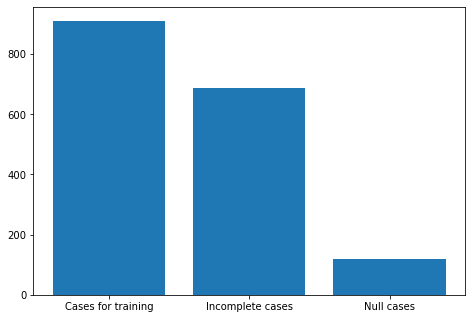

In [22]:
total_training_cases = len(summary_cases['informative_cases'])
total_incomplete_cases = len(summary_cases['incomplete_cases'])
total_null_cases = len(summary_cases['null_cases'])

print('Interpolation done \n')
print(f"Total of cases employed for training and validation: {total_training_cases}")             
print(f'Total of cases with not enough information: {total_incomplete_cases}')  
print(f'Total of cases with null information: {total_null_cases}')  


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cases = ['Cases for training', 'Incomplete cases', 'Null cases']
cases_count = [total_training_cases, total_incomplete_cases, total_null_cases]
ax.bar(cases, cases_count)

# Eliminate full zero inputs
valid_indexes = np.all(dataset_input == 0, axis=1)
dataset_input = dataset_input[~valid_indexes]
dataset_output = dataset_output[~valid_indexes]

## Set the dataset input/output information for the Neural network

In [23]:
# Input format: (N x 6), N samples of 6 consecutive stock values
# Output format: (N x 6), N samples of 6 consecutive stok values shifted 3 time instances wrt the input
dataset_input_net = dataset_input.reshape((-1, 6, 1))
dataset_output_net = dataset_output.reshape((-1, 6, 1))
dataset_final = (dataset_input_net, dataset_output_net)
filehandler = open('dataset_final.pkl', 'wb') 
pkl.dump(dataset_final, filehandler)
filehandler.close()